In [1]:
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
from matplotlib import pyplot
from mlxtend.feature_selection import SequentialFeatureSelector as sffs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from numpy import *
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from numpy.random import seed
from pandas import read_csv
from random import randint
from random import random
from random import seed
from scipy import stats # For in-built method to get PCC
from sklearn import linear_model
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import sklearn
from sklearn.preprocessing import *

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.stats.outliers_influence import OLSInfluence
from tqdm import tnrange, tqdm_notebook
from zca import zca
import itertools
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import pingouin as pg
import scipy
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys

#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")
#import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
class ss_yj_Transformer(BaseEstimator, TransformerMixin):
    # add another additional parameter, just for fun, while we are at it
    
    def __init__(self, feature_names=[], additional_param = ""):  
        self.ss_X = StandardScaler()
        self.pt_X = PowerTransformer(standardize=True)
        self.ss_y = StandardScaler()
        self.pt_y = PowerTransformer(standardize=True)        
        self.feature_names = feature_names
        self.additional_param = additional_param

    def fit(self, X, y = None):
        self.ss_X.fit(X)
        self.pt_X.fit(self.ss_X.transform(X))
        if (y is not None):
            self.ss_y.fit(y)
            self.pt_y.fit(self.ss_y.transform(y))
        return self

    def transform(self, X, y = None):
        pt_X_ = pd.DataFrame(self.pt_X.fit(pd.DataFrame(self.ss_X.fit(X).transform(X),index=X.index,columns=X.columns)).transform(pd.DataFrame(self.ss_X.fit(X).transform(X),index=X.index,columns=X.columns)),index=X.index,columns=X.columns)        
        if (y is None):
            return pt_X_
        else:
            pt_y_ = pd.DataFrame(self.pt_y.fit(pd.DataFrame(self.ss_y.fit(y).transform(y),index=y.index,columns=y.columns)).transform(pd.DataFrame(self.ss_y.fit(y).transform(y),index=y.index,columns=y.columns)),index=y.index,columns=y.columns)
            return pt_X_, pt_y_
        
    def inverse_transform(self, X, y = None):
        target_X = pd.DataFrame(self.ss_X.inverse_transform(self.pt_X.inverse_transform(X)),index=X.index,columns=X.columns)
        if (y is None):
            return target_X
        else:
            target_y = pd.DataFrame(self.ss_y.inverse_transform(self.pt_y.inverse_transform(y)),index=y.index,columns=y.columns)
            return target_X, target_y
        

In [3]:
numCV = 10
kfold = KFold(n_splits=numCV, shuffle=True)
p_threshold = .05
divisor = 1
target = 'Poverty'
exclude = 'States'


cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
l1s = arange(0, 1, 0.01/divisor)

seed_ = 3

#random.seed(11)

seed(seed_)

In [4]:
# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()

In [5]:
all_data = pd.read_csv('../data/raw/states.csv')

In [6]:
class data():
    def __init__(self, target, exclude, dataset):  
        
        train, valid = train_test_split(all_data.index, test_size=0.3, shuffle=True)
        valid, test = train_test_split(valid,  test_size=0.5, shuffle=True)

        self.X = dataset[set(all_data.columns).difference([target,exclude])].copy()
        self.y = pd.DataFrame(all_data[target].copy())

        self.X_train = self.X.loc[train].copy()

        self.X_train_ss_yj_t = ss_yj_Transformer()
        self.X_train_ss_yj_t.fit(self.X_train)
        
        self.X_train_ss_yj = self.X_train_ss_yj_t.transform(self.X_train)

        self.X_valid = self.X.loc[valid].copy()

        self.X_test = self.X.loc[test].copy()

        self.y_train = self.y.loc[self.X_train.index][[target]].copy()
        self.y_valid = self.y.loc[self.X_valid.index][[target]].copy()
        self.y_test = self.y.loc[self.X_test.index][[target]].copy()

        self.y_train_ss_yj_t = ss_yj_Transformer()
        self.y_train_ss_yj_t.fit(self.y_train)
        
        self.y_train_ss_yj = self.y_train_ss_yj_t.transform(self.y_train)

        self.X_valid_ss_yj = self.X_train_ss_yj_t.transform(self.X_valid)
        
        interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

        self.X_train_ss_yj_inter = pd.DataFrame(interaction.fit_transform(self.X_train_ss_yj),index=self.X_train_ss_yj.index,columns=interaction.get_feature_names(input_features=self.X_train_ss_yj.columns))

        self.X_valid_ss_yj_inter = pd.DataFrame(interaction.fit_transform(self.X_valid_ss_yj),index=self.X_valid_ss_yj.index,columns=interaction.get_feature_names(input_features=self.X_valid_ss_yj.columns))
        
        self.zca = zca.ZCA()
        self.pca_X_train = PCA(n_components=0.99, svd_solver='full')


In [7]:
data = data(target,exclude,all_data)

In [8]:
lr = LinearRegression()

#backwards step subset
sffs1 = sffs(lr, 
          k_features=len(data.X_train_ss_yj_inter.columns), 
          #forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          #scoring='accuracy',
          n_jobs=-1,
          cv=numCV)
            
sffs1 = sffs1.fit(data.X_train_ss_yj_inter, data.y_train_ss_yj)


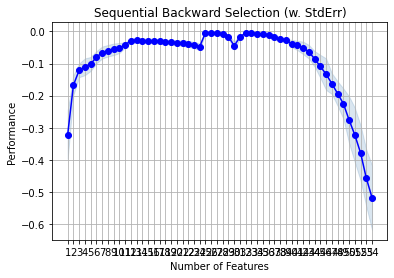

best combination (ACC: -0.518): (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53)



Index(['Crime', 'Doctors', 'University', 'Traf Deaths', 'White', 'Infant Mort',
       'Income', 'Population', 'Unemployed', 'Crime^2', 'Crime Doctors',
       'Crime University', 'Crime Traf Deaths', 'Crime White',
       'Crime Infant Mort', 'Crime Income', 'Crime Population',
       'Crime Unemployed', 'Doctors^2', 'Doctors University',
       'Doctors Traf Deaths', 'Doctors White', 'Doctors Infant Mort',
       'Doctors Income', 'Doctors Population', 'Doctors Unemployed',
       'University^2', 'University Traf Deaths', 'University White',
       'University Infant Mort', 'University Income', 'University Population',
       'University Unemployed', 'Traf Deaths^2', 'Traf Deaths White',
       'Traf Deaths Infant Mort', 'Traf Deaths Income',
       'Traf Deaths Population', 'Traf Deaths Unemployed', 'White^2',
       'White Infant Mort', 'White Income', 'White Population',
       'White Unemployed', 'Infant Mort^2', 'Infant Mort Income',
       'Infant Mort Population', 'Infant Mort

In [9]:
fig = plot_sfs(sffs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show(fig)

print('best combination (ACC: %.3f): %s\n' % (sffs1.k_score_, sffs1.k_feature_idx_))
#print('all subsets:\n', sffs1.subsets_)
data.X_train_ss_yj_inter.columns[list(sffs1.k_feature_idx_)]

In [10]:
features = list(pd.DataFrame(sffs1.subsets_).loc['feature_names'].values)

In [11]:
ss_position = np.array(pd.DataFrame(pd.DataFrame(sffs1.subsets_)).loc['avg_score']).argmax()

In [12]:
ss_position_parse = list((pd.DataFrame(sffs1.subsets_)).T[(pd.DataFrame(sffs1.subsets_)).T['avg_score']>=np.max(np.array(pd.DataFrame(pd.DataFrame(sffs1.subsets_)).loc['avg_score']))-np.std(np.array(pd.DataFrame(pd.DataFrame(sffs1.subsets_)).loc['avg_score']))]['feature_names'].iloc[0])

In [13]:
ss_sortedFeatures = list(np.array(pd.DataFrame(sffs1.subsets_).loc['feature_names'])[ss_position])

In [14]:
CV_results = pd.DataFrame()#[]#np.zeros(shape=(len(features),5))

#looping over sequentially selected features, deriving ElasticNet hyper parm's over each best subset and noting error

for f in features:

    print(f)
    cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

    EN_CV = ElasticNetCV(l1_ratio=l1s, alphas=alphas, cv=cv, n_jobs=-1)
    # fit model

    X_subset = pd.DataFrame(data.X_train_ss_yj_inter[list(np.asarray(f))])
    y_ = data.y_train_ss_yj
    EN_CV.fit(X_subset, y_)
    
    print('alpha: %f' % EN_CV.alpha_)
    print('l1_ratio_: %f' % EN_CV.l1_ratio_)
    
    # evaluate model
    scores = cross_val_score(EN_CV, X_subset, y_, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    
    temp = pd.concat([pd.DataFrame({"features": [np.array(f)]}),pd.DataFrame(np.array(mean(scores)).reshape(-1,1)),pd.DataFrame(np.array(std(scores)).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.alpha_).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.l1_ratio_).reshape(-1,1))],axis=1)
    
    CV_results = pd.concat([CV_results,temp],axis=0)

('Income',)
alpha: 0.010000
l1_ratio_: 0.000000
Mean MAE: 0.486 (0.187)
('Income', 'Population')
alpha: 0.000000
l1_ratio_: 0.580000
Mean MAE: 0.338 (0.131)
('Income', 'Population', 'Unemployed')
alpha: 0.000010
l1_ratio_: 0.120000
Mean MAE: 0.282 (0.077)
('Income', 'Population', 'Unemployed', 'Infant Mort Population')
alpha: 0.001000
l1_ratio_: 0.990000
Mean MAE: 0.251 (0.103)
('White', 'Income', 'Population', 'Unemployed', 'Infant Mort Population')
alpha: 0.000000
l1_ratio_: 0.480000
Mean MAE: 0.246 (0.096)
('Traf Deaths', 'Income', 'Population', 'Unemployed', 'Doctors Population', 'Infant Mort Population')
alpha: 0.000000
l1_ratio_: 0.240000
Mean MAE: 0.216 (0.065)
('Traf Deaths', 'Income', 'Population', 'Unemployed', 'Crime Traf Deaths', 'Doctors Population', 'Infant Mort Population')
alpha: 0.000000
l1_ratio_: 0.230000
Mean MAE: 0.199 (0.090)
('Traf Deaths', 'Income', 'Population', 'Unemployed', 'Crime Traf Deaths', 'Doctors Population', 'Doctors Unemployed', 'Infant Mort Populati

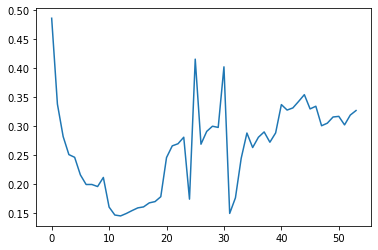

['Doctors' 'University' 'Traf Deaths' 'Income' 'Population' 'Unemployed'
 'Crime Traf Deaths' 'Crime Population' 'Crime Unemployed'
 'Doctors Population' 'Doctors Unemployed' 'University Traf Deaths'
 'White Unemployed']
['Traf Deaths' 'Income' 'Population' 'Unemployed' 'Doctors Population'
 'Infant Mort Population']


,features,mean error,std,alpha,lambda
0,[Income],0.486318,0.187417,0.01000,0.00
1,"[Income, Population]",0.337883,0.130754,0.00000,0.58
2,"[Income, Population, Unemployed]",0.281766,0.077191,0.00001,0.12
3,"[Income, Population, Unemployed, Infant Mort P...",0.250534,0.103187,0.00100,0.99
4,"[White, Income, Population, Unemployed, Infant...",0.245878,0.095867,0.00000,0.48
5,"[Traf Deaths, Income, Population, Unemployed, ...",0.215510,0.065123,0.00000,0.24
6,"[Traf Deaths, Income, Population, Unemployed, ...",0.198847,0.089684,0.00000,0.23
7,"[Traf Deaths, Income, Population, Unemployed, ...",0.198897,0.092794,0.00100,0.10
8,"[Traf Deaths, Income, Population, Unemployed, ...",0.195324,0.101924,0.01000,0.00
9,"[Traf Deaths, Income, Population, Unemployed, ...",0.211045,0.061444,0.01000,0.27


In [15]:
CV_results.columns = ['features','mean error','std','alpha','lambda']
CV_results.index = np.array(range(0,len(features)))#range(1,len(features)+1)
plt.plot(CV_results['mean error'])
plt.show()

best = CV_results.iloc[CV_results['mean error'].idxmin()]
print(best.loc['features'])

parse = CV_results[CV_results['mean error']<=(np.min(CV_results['mean error'])+np.std(CV_results['mean error']))].iloc[0]
print(parse.loc['features'])
display(CV_results)

In [16]:
model_ss = LinearRegression()
model_ss_parse = LinearRegression()
model_ep = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])
model_eb = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

model_ss.fit(data.X_train_ss_yj_inter[ss_sortedFeatures], data.y_train_ss_yj)
model_ss_parse.fit(data.X_train_ss_yj_inter[ss_position_parse], data.y_train_ss_yj)
model_ep.fit(data.X_train_ss_yj_inter[parse['features']],data.y_train_ss_yj)
model_eb.fit(data.X_train_ss_yj_inter[best['features']],data.y_train_ss_yj)

ElasticNet(alpha=0.01, l1_ratio=0.0)

In [17]:
data.zca_X_train = pd.DataFrame(data.zca.fit_transform(data.X_train_ss_yj_inter[ss_position_parse]),columns=ss_position_parse,index=data.X_train_ss_yj_inter.index)
data.zca_X_train.index = data.X_train_ss_yj_inter.index
#zca_data = pd.concat([y_train_ss_yj,zca_X_train],axis=1)
#zca_data.index = X_train_ss_yj_inter.index

In [18]:
data.pca_X_train.fit(data.X_train_ss_yj_inter[ss_sortedFeatures])
data.X_pca_train = pd.DataFrame(data.pca_X_train.transform(data.X_train_ss_yj_inter[ss_sortedFeatures]),index = data.X_train_ss_yj_inter.index)

In [19]:
#zca_data.pcorr()

In [20]:
#sns.pairplot(zca_data,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [21]:
data.pca_X_train.explained_variance_ratio_.cumsum()

array([0.22788469, 0.38735997, 0.51170292, 0.61349398, 0.69010628,
       0.75431235, 0.80609821, 0.8477879 , 0.87754276, 0.90619932,
       0.9290456 , 0.9446698 , 0.95804198, 0.96747421, 0.97638492,
       0.98340357, 0.98864426, 0.99191737])

In [22]:
len(ss_sortedFeatures)

25

In [23]:
print(ss_position_parse)

['Income', 'Population', 'Unemployed', 'Infant Mort Population']


In [24]:
#model = sklearn.linear_model.LinearRegression()
#data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
data_set_wConstant_parse_zca = statsmodels.tools.tools.add_constant(data.zca_X_train)
#y_ = data_set_wConstant[target]
#data_set_wConstant = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model_parse = sm.OLS(data.y_train_ss_yj,data_set_wConstant_parse_zca)
results_parse = model_parse.fit()
fitted_parse = results_parse.predict(data_set_wConstant_parse_zca)
results_parse.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     83.25
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           8.46e-16
Time:                        17:31:21   Log-Likelihood:                -6.0312
No. Observations:                  35   AIC:                             22.06
Df Residuals:                      30   BIC:                             29.84
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -6.939e-17      0.052  -1.32e-15      1.000      -0.107       0.107
Income                    -0.8836      0.053    -16.592      0.000      -0.992      -0.775
Population                 0.2603      0.053      4.887      0.000       0.152       0.369
Unemployed                 0.3069      0.053      5.764      0.000       0.198       0.416
Infant Mort Population    -0.0412      0.053     -0.773      0.446      -0.150       0.068
==============================================================================
Omnibus:                        0.613   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.094
Skew:                           0.080   Prob(JB):                        0.954
Kurtosis:                       3.198   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     83.25
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           8.46e-16
Time:                        17:31:21   Log-Likelihood:                -6.0312
No. Observations:                  35   AIC:                             22.06
Df Residuals:                      30   BIC:                             29.84
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.939e-17      0.

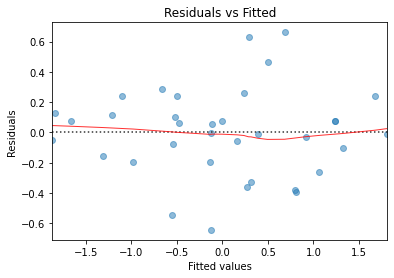

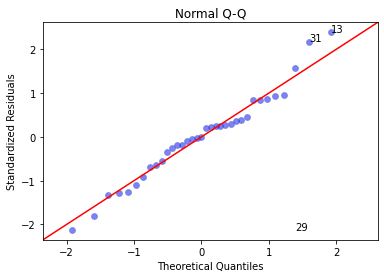

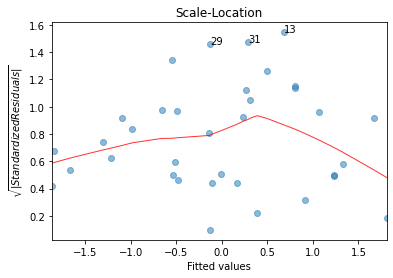

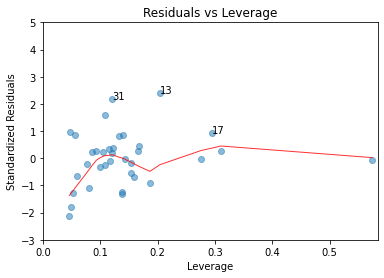

In [25]:
linear_plot = Plot.LinearRegressionResidualPlot(data_set_wConstant_parse_zca.values, data.y_train_ss_yj.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

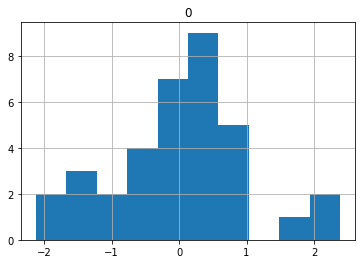

In [26]:
pd.DataFrame(results_parse.get_influence().resid_studentized_internal).hist()

In [27]:
print(ss_sortedFeatures)

['University', 'Traf Deaths', 'Population', 'Unemployed', 'Crime^2', 'Crime Doctors', 'Crime University', 'Crime Traf Deaths', 'Crime White', 'Crime Infant Mort', 'Doctors Traf Deaths', 'Doctors Income', 'Doctors Population', 'Doctors Unemployed', 'University Infant Mort', 'University Income', 'University Population', 'Traf Deaths White', 'Traf Deaths Infant Mort', 'Traf Deaths Income', 'White Infant Mort', 'Infant Mort Income', 'Infant Mort Population', 'Income Population', 'Income Unemployed']


In [28]:
#model = sklearn.linear_model.LinearRegression()
#data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
data_set_wConstant_ss_pca = statsmodels.tools.tools.add_constant(data.X_pca_train)
#y_ = data_set_wConstant[target]
#data_set_wConstant = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model_ss = sm.OLS(data.y_train_ss_yj,data_set_wConstant_ss_pca)
results_ss = model_ss.fit()
fitted = results_ss.predict(data_set_wConstant_ss_pca)
results_ss.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     17.80
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           2.39e-07
Time:                        17:31:23   Log-Likelihood:                 3.6343
No. Observations:                  35   AIC:                             30.73
Df Residuals:                      16   BIC:                             60.28
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.939e-17      0.055  -1.27e-15      1.000      -0.116       0.116
0              0.0059      0.024      0.246      0.809      -0.045       0.056
1              0.1210      0.028      4.250      0.001       0.061       0.181
2             -0.1520      0.032     -4.712      0.000      -0.220      -0.084
3              0.2762      0.036      7.750      0.000       0.201       0.352
4             -0.2623      0.041     -6.385      0.000      -0.349      -0.175
5              0.0793      0.045      1.767      0.096      -0.016       0.174
6              0.4770      0.050      9.545      0.000       0.371       0.583
7             -0.2338      0.056     -4.198      0.001      -0.352      -0.116
8             -0.3317      0.066     -5.031      0.000      -0.471      -0.192
9             -0.0767      0.067     -1.142      0.270      -0.219       0.066
10            -0.2740      0.075     -3.642      0.002      -0.433      -0.114
11             0.3227      0.091      3.548      0.003       0.130       0.516
12            -0.1334      0.098     -1.357      0.194      -0.342       0.075
13            -0.1103      0.117     -0.942      0.360      -0.359       0.138
14             0.1945      0.120      1.615      0.126      -0.061       0.450
15            -0.1766      0.136     -1.301      0.212      -0.464       0.111
16            -0.1996      0.157     -1.270      0.222      -0.533       0.133
17             0.4956      0.199      2.493      0.024       0.074       0.917
==============================================================================
Omnibus:                        5.781   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                7.286
Skew:                           0.098   Prob(JB):                       0.0262
Kurtosis:                       5.227   Cond. No.                         8.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

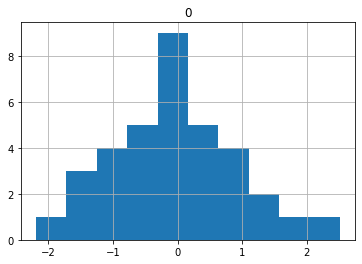

In [29]:
pd.DataFrame(results_ss.get_influence().resid_studentized_internal).hist()

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     17.80
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           2.39e-07
Time:                        17:31:23   Log-Likelihood:                 3.6343
No. Observations:                  35   AIC:                             30.73
Df Residuals:                      16   BIC:                             60.28
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.939e-17      0.

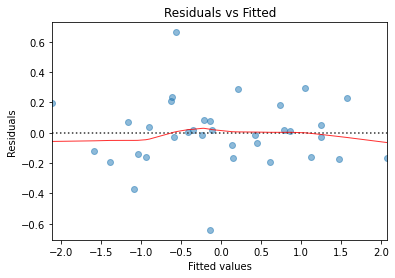

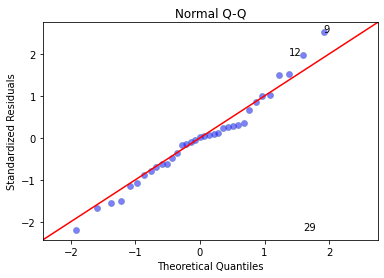

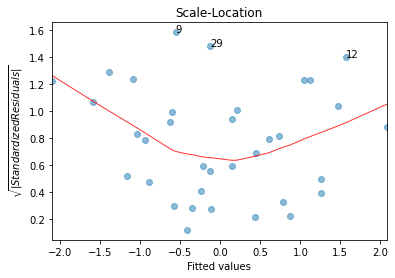

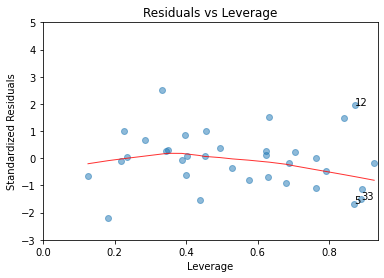

In [30]:
linear_plot = Plot.LinearRegressionResidualPlot(data_set_wConstant_ss_pca.values, data.y_train_ss_yj.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))


Mean Absolute Error
Poverty    2.366079
dtype: float64


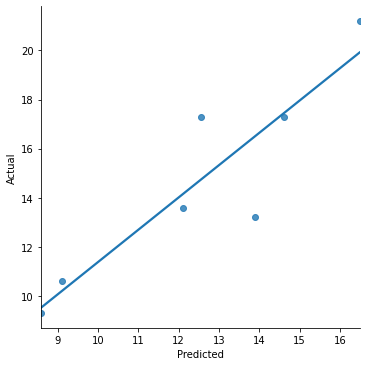

In [31]:
#ols parse
#uses ZCA
y_train_predicted = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(results_parse.fittedvalues,columns=[target]))

y_valid_ss_fitted_parse = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(results_parse.predict(sm.tools.tools.add_constant(data.zca.transform(data.X_valid_ss_yj_inter[ss_position_parse]), prepend=True, has_constant='skip')),index=data.X_valid_ss_yj_inter.index,columns=[target]))
# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(data.y_valid-y_valid_ss_fitted_parse)))

#temp = pd.concat([y_train_predicted,y_train_original],axis=1)
temp = pd.concat([y_valid_ss_fitted_parse,data.y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean Absolute Error
Poverty    2.609777
dtype: float64


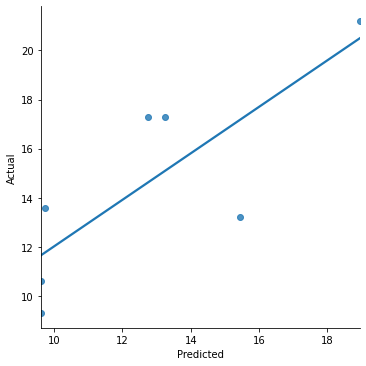

In [32]:
#ols best
#uses PCA
y_train_predicted = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(results_ss.fittedvalues,columns=[target]))

y_valid_ss_fitted = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(results_ss.predict(sm.tools.tools.add_constant(data.pca_X_train.transform(data.X_valid_ss_yj_inter[ss_sortedFeatures]), prepend=True, has_constant='skip')),index=data.X_valid_ss_yj_inter.index,columns=[target]))
# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(data.y_valid-y_valid_ss_fitted)))

#temp = pd.concat([y_train_predicted,y_train_original],axis=1)
temp = pd.concat([y_valid_ss_fitted,data.y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean Absolute Error
Poverty    2.96117
dtype: float64


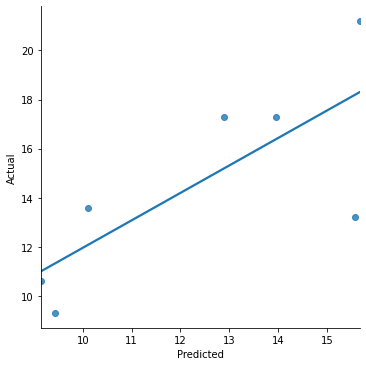

In [33]:
#EN Best

ENBestResults = model_eb.fit(data.X_train_ss_yj_inter[best['features']], data.y_train_ss_yj)

ENBestFitted = pd.DataFrame(model_eb.predict(data.X_train_ss_yj_inter[best['features']]),index=data.X_train_ss_yj_inter.index, columns = [target])

y_valid_eb_fitted = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(model_eb.predict(data.X_valid_ss_yj_inter[best['features']]),index=data.X_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_eb_fitted-data.y_valid)))

temp = pd.concat([y_valid_eb_fitted,data.y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean Absolute Error
Poverty    2.44659
dtype: float64


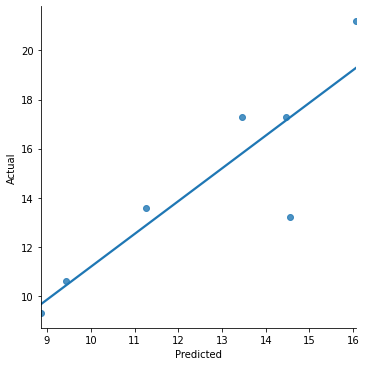

In [34]:
#EN Parse

ENParseResults = model_ep.fit(data.X_train_ss_yj_inter[parse['features']], data.y_train_ss_yj)

ENParseFitted = pd.DataFrame(model_ep.predict(data.X_train_ss_yj_inter[parse['features']]),index=data.X_train_ss_yj_inter.index,columns=[target])

y_valid_ep_fitted = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(model_ep.predict(data.X_valid_ss_yj_inter[parse['features']]),index=data.X_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_ep_fitted-data.y_valid)))

temp = pd.concat([y_valid_ep_fitted,data.y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean MAE: 0.959 (0.430)
Mean Absolute Error
Poverty    2.584896
dtype: float64


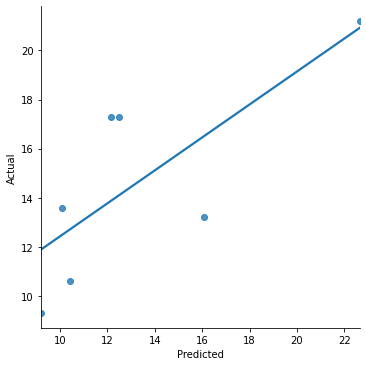

In [35]:
#robust regression using ols best
# define the model
model_rr_ss = RANSACRegressor()
# evaluate model
#Rresults_ss = evaluate_model(X_train_ss_yj_inter[ss_sortedFeatures], y_train_ss_yj, model_rr_ss)
Rresults_ss = evaluate_model(data.X_pca_train, data.y_train_ss_yj, model_rr_ss)

print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_ss), std(Rresults_ss)))
# plot the line of best fit
#Rresults_ss = model_rr_ss.fit(X_train_ss_yj_inter[ss_sortedFeatures],y_train_ss_yj)
Rresults_ss = model_rr_ss.fit(data.X_pca_train,data.y_train_ss_yj)
RFitted_ss = model_rr_ss.predict(data.pca_X_train.transform(data.X_train_ss_yj_inter[ss_sortedFeatures]))

y_valid_rr_ss_fitted_best = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(model_rr_ss.predict(data.pca_X_train.transform(data.X_valid_ss_yj_inter[ss_sortedFeatures])),index=data.X_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_ss_fitted_best-data.y_valid)))

temp = pd.concat([y_valid_rr_ss_fitted_best,data.y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);


Mean MAE: 0.277 (0.096)
Mean Absolute Error
Poverty    2.387328
dtype: float64


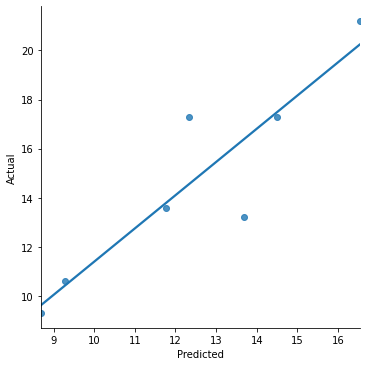

In [36]:
#robust regression using ols parse
# define the model
model_rr_ss = RANSACRegressor()
# evaluate model
#Rresults_ss = evaluate_model(X_train_ss_yj_inter[ss_sortedFeatures], y_train_ss_yj, model_rr_ss)
Rresults_ss = evaluate_model(data_set_wConstant_parse_zca, data.y_train_ss_yj, model_rr_ss)

print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_ss), std(Rresults_ss)))
# plot the line of best fit
#Rresults_ss = model_rr_ss.fit(X_train_ss_yj_inter[ss_sortedFeatures],y_train_ss_yj)
Rresults_ss = model_rr_ss.fit(data_set_wConstant_parse_zca,data.y_train_ss_yj)
#RFitted_ss = model_rr_ss.predict(data_set_wConstant_parse_zca)

y_valid_rr_ss_fitted_parse = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(Rresults_ss.predict(sm.tools.tools.add_constant(data.zca.transform(data.X_valid_ss_yj_inter[ss_position_parse]), prepend=True, has_constant='skip')),index=data.X_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_ss_fitted_parse-data.y_valid)))

temp = pd.concat([y_valid_rr_ss_fitted_parse,data.y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);


Mean MAE: 0.194 (0.073)
Mean Absolute Error
Poverty    2.984681
dtype: float64


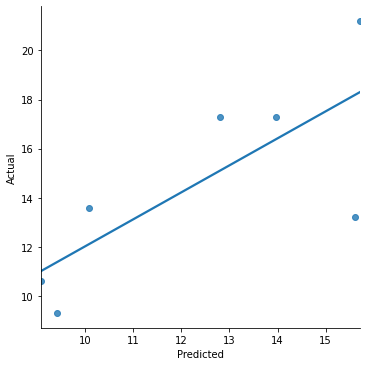

In [37]:
#robust regression using EN best
# define the model
model_rr_best = RANSACRegressor()
# evaluate model
Rresults_best = evaluate_model(data.X_train_ss_yj_inter[best['features']], data.y_train_ss_yj, model_rr_best)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_best), std(Rresults_best)))
# plot the line of best fit
Rresults_best = model_rr_best.fit(data.X_train_ss_yj_inter[best['features']],data.y_train_ss_yj)
RFitted_best = model_rr_best.predict(data.X_train_ss_yj_inter[best['features']])

y_valid_rr_en_best_fitted = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(model_rr_best.predict(data.X_valid_ss_yj_inter[best['features']]),index=data.X_valid_ss_yj_inter.index,columns=[target]))
# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_en_best_fitted-data.y_valid)))

temp = pd.concat([y_valid_rr_en_best_fitted,data.y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean MAE: 0.177 (0.108)
Mean Absolute Error
Poverty    2.483838
dtype: float64


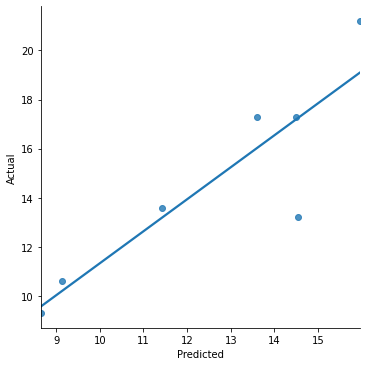

In [38]:
#robust regression using EN parse
# define the model
model_rr_parse = RANSACRegressor()
# evaluate model
Rresults_parse = evaluate_model(data.X_train_ss_yj_inter[best['features']], data.y_train_ss_yj, model_rr_parse)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_parse), std(Rresults_parse)))
# plot the line of best fit
Rresults_parse = model_rr_parse.fit(data.X_train_ss_yj_inter[parse['features']],data.y_train_ss_yj)
RFitted_parse = model_rr_parse.predict(data.X_train_ss_yj_inter[parse['features']])

y_valid_rr_en_parse_fitted = data.y_train_ss_yj_t.inverse_transform(pd.DataFrame(Rresults_parse.predict(data.X_valid_ss_yj_inter[parse['features']]),index=data.X_valid_ss_yj_inter.index,columns=[target]))

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_en_parse_fitted-data.y_valid)))

temp = pd.concat([y_valid_rr_en_parse_fitted,data.y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [39]:
print("OLS SS: " + str(mean(absolute(np.array(data.y_valid)-y_valid_ss_fitted))))
print("OLS parse: " + str(mean(absolute(np.array(data.y_valid)-y_valid_ss_fitted_parse))))

print("EN best: " + str(mean(absolute(np.array(data.y_valid)-y_valid_eb_fitted))))
print("EN parse: " + str(mean(absolute(np.array(data.y_valid)-y_valid_ep_fitted))))

print("RR SS-best: " + str(mean(absolute(np.array(data.y_valid)-y_valid_rr_ss_fitted_best))))
print("RR SS-parse: " + str(mean(absolute(np.array(data.y_valid)-y_valid_rr_ss_fitted_parse))))

print("RR best: " + str(mean(absolute(np.array(data.y_valid)-y_valid_rr_en_best_fitted))))
print("RR parse: " + str(mean(absolute(np.array(data.y_valid)-y_valid_rr_en_parse_fitted))))

OLS SS: Poverty    2.609777
dtype: float64
OLS parse: Poverty    2.366079
dtype: float64
EN best: Poverty    2.96117
dtype: float64
EN parse: Poverty    2.44659
dtype: float64
RR SS-best: Poverty    2.584896
dtype: float64
RR SS-parse: Poverty    2.387328
dtype: float64
RR best: Poverty    2.984681
dtype: float64
RR parse: Poverty    2.483838
dtype: float64


In [40]:
#print("RR parse: " + str(mean(absolute(np.array(y)-RFitted_parse_all))))
#print("RR ss: " + str(mean(absolute(np.array(y)-RFitted_ss_all))))